## Data and Steps of the last week

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [4]:
df = pd.read_csv('data-week-3.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [6]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [7]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

/home/ls/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [8]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

## Accuracy and Dummy Model

In [9]:
len(y_val)

1409

In [10]:
(y_val == churn_decision).sum()

1132

In [11]:
# accuracy = number of right classifications / n of total examples
(y_val == churn_decision).sum() / len(y_val)

0.8034066713981547

In [12]:
from sklearn.metrics import accuracy_score

In [13]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [14]:
thresholds = np.linspace(0, 1, 21)

In [15]:
scores = []

for t in thresholds:
    churn_decision = (y_pred >= t)
    score = accuracy_score(y_val, y_pred >= t)
    
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.667
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.765
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


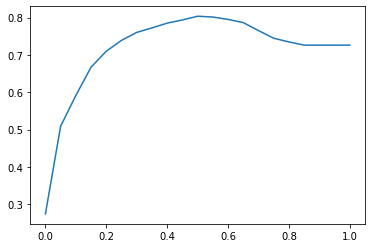

In [16]:
plt.plot(thresholds, scores)

In [17]:
from collections import Counter

Counter(y_pred >= 1.0)

Counter({False: 1409})

In [18]:
# accuracy could not be good for unbalance data
Counter(y_val)

Counter({0: 1023, 1: 386})

## Confusion Table

In [19]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [20]:
t = 0.5
predict_pos = (y_pred >= t)
predict_neg = (y_pred < t)

In [21]:
predict_pos & actual_positive

array([False, False, False, ..., False,  True,  True])

In [22]:
tp = (predict_pos & actual_positive).sum()
tn = (predict_neg & actual_negative).sum()

fp = (predict_pos & actual_negative).sum()
fn = (predict_neg & actual_positive).sum()

In [23]:
confusion_matrix = np.array([
    [tn, fp], 
    [fn, tp]])

confusion_matrix

array([[922, 101],
       [176, 210]])

In [24]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## Precision and Recall

* Precision: fraction of positive predictions that are correct
    $$ P = \dfrac{tp}{tp + fp} $$

* Recall: fraction of correctly identified positive examples
    $$ R = \dfrac{tp}{tp + fn} $$

In [25]:
p = tp / (tp + fp)
p

0.6752411575562701

In [26]:
r = tp / (tp + fn)
r

0.5440414507772021

In [27]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
accuracy

0.8034066713981547

## ROC (Receiver operating characteristic) Curves

* False Positive Rate
    $$ FPR = \dfrac{fp}{fp + tn} $$  
    
* True Positive Rate
    $$ TPR = \dfrac{tp}{tp + fn} $$  

In [28]:
tpr = tp / (tp + fn)
tpr

0.5440414507772021

In [30]:
fpr = fp / (fp + tn)
fpr

0.09872922776148582

In [36]:
thresholds = np.linspace(0, 1, 100)

scores = []

for t in thresholds:
    
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_pos = (y_pred >= t)
    predict_neg = (y_pred < t)

    tp = (predict_pos & actual_positive).sum()
    tn = (predict_neg & actual_negative).sum()

    fp = (predict_pos & actual_negative).sum()
    fn = (predict_neg & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [37]:
df_scores = pd.DataFrame(scores, columns=['t', 'tp', 'fp', 'fn', 'tn'])

In [38]:
df_scores[::10]

,t,tp,fp,fn,tn
0,0.000000,386,1023,0,0
10,0.101010,366,550,20,473
20,0.202020,333,354,53,669
30,0.303030,283,234,103,789
40,0.404040,249,164,137,859
50,0.505051,208,100,178,923
60,0.606061,147,49,239,974
70,0.707071,68,15,318,1008
80,0.808081,7,0,379,1023
90,0.909091,0,0,386,1023


In [39]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

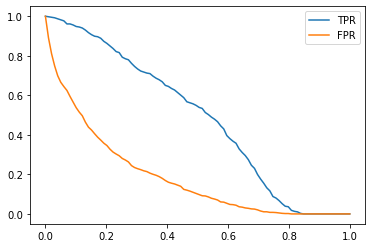

In [40]:
plt.plot(df_scores.t, df_scores.tpr, label='TPR')
plt.plot(df_scores.t, df_scores.fpr, label='FPR')
plt.legend()

### Random model

In [48]:
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [49]:
y_rand.round(3)

array([0.394, 0.516, 0.643, ..., 0.994, 0.645, 0.045])

In [50]:
((y_rand >= 0.5) == y_val).mean() # accuracy

0.4982256919801277

In [54]:
def tpr_fpr_df(y_val, y_pred):
    
    thresholds = np.linspace(0, 1, 101)

    scores = []

    for t in thresholds:

        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_pos = (y_pred >= t)
        predict_neg = (y_pred < t)

        tp = (predict_pos & actual_positive).sum()
        tn = (predict_neg & actual_negative).sum()

        fp = (predict_pos & actual_negative).sum()
        fn = (predict_neg & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    df_scores = pd.DataFrame(scores, columns=['t', 'tp', 'fp', 'fn', 'tn'])

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [55]:
df_rand = tpr_fpr_df(y_val, y_rand)
df_rand

,t,tp,fp,fn,tn,tpr,fpr
0,0.00,386,1023,0,0,1.000000,1.000000
1,0.01,383,1012,3,11,0.992228,0.989247
2,0.02,378,996,8,27,0.979275,0.973607
3,0.03,375,978,11,45,0.971503,0.956012
4,0.04,369,960,17,63,0.955959,0.938416
...,...,...,...,...,...,...,...
96,0.96,17,42,369,981,0.044041,0.041056
97,0.97,13,33,373,990,0.033679,0.032258
98,0.98,9,17,377,1006,0.023316,0.016618
99,0.99,5,9,381,1014,0.012953,0.008798


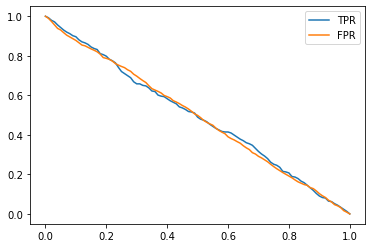

In [56]:
plt.plot(df_rand.t, df_rand.tpr, label='TPR')
plt.plot(df_rand.t, df_rand.fpr, label='FPR')
plt.legend()

### Ideal model

In [57]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

num_neg, num_pos

(1023, 386)

In [58]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [59]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [60]:
((y_ideal_pred >= 0.72) == y_ideal).mean()

0.99361249112846

In [61]:
df_ideal = tpr_fpr_df(y_ideal, y_ideal_pred)
df_ideal.head()

,t,tp,fp,fn,tn,tpr,fpr
0,0.00,386,1023,0,0,1.0,1.000000
1,0.01,386,1008,0,15,1.0,0.985337
2,0.02,386,994,0,29,1.0,0.971652
3,0.03,386,980,0,43,1.0,0.957967
4,0.04,386,966,0,57,1.0,0.944282


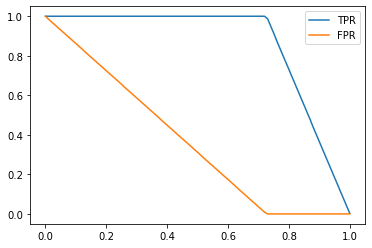

In [62]:
plt.plot(df_ideal.t, df_ideal.tpr, label='TPR')
plt.plot(df_ideal.t, df_ideal.fpr, label='FPR')
plt.legend()

### Putting everything together

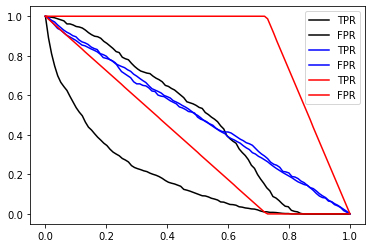

In [64]:
plt.plot(df_scores.t, df_scores.tpr, label='TPR', color='black')
plt.plot(df_scores.t, df_scores.fpr, label='FPR', color='black')

plt.plot(df_rand.t, df_rand.tpr, label='TPR', color='blue')
plt.plot(df_rand.t, df_rand.fpr, label='FPR', color='blue')

plt.plot(df_ideal.t, df_ideal.tpr, label='TPR', color='red')
plt.plot(df_ideal.t, df_ideal.fpr, label='FPR', color='red')
plt.legend()

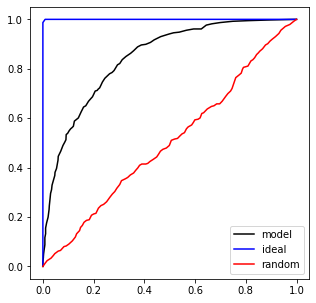

In [66]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='model', color='black')

#plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal', color='blue')

plt.plot(df_rand.fpr, df_rand.tpr, label='random', color='red')
plt.legend()

## Plotting ROC Curves With Scikit-Learn

In [67]:
from sklearn.metrics import roc_curve

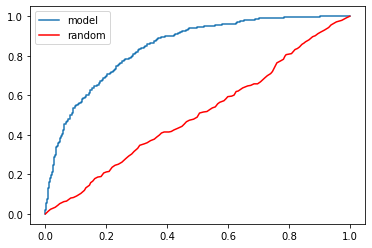

In [69]:
fpr, tpr, t = roc_curve(y_val, y_pred)

plt.plot(fpr, tpr, label='model')
plt.plot(df_rand.fpr, df_rand.tpr, label='random', color='red')

plt.legend()

## Area Under the ROC Curve (AUC)

AUC = Probability that randomly selected a positive example has higher score than randomly selected a negative example.

In [70]:
from sklearn.metrics import auc

In [71]:
auc(fpr, tpr)

0.8438175841652359

In [72]:
auc(df_scores.fpr, df_scores.tpr)

0.8436200548017362

In [73]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [74]:
from sklearn.metrics import roc_auc_score

In [75]:
roc_auc_score(y_val, y_pred)

0.8438175841652359

In [76]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [77]:
import random

In [80]:
n = 100000

success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success += 1
    
success / n

0.84363

In [81]:
n = 100000

np.random.seed(1)

p_ix = np.random.randint(0, len(pos), size=n)
n_ix = np.random.randint(0, len(neg), size=n)

(pos[p_ix] > neg[n_ix]).mean()

0.84284

## Cross-Validation

In [106]:
def train(df, y_train, C=1.0):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [108]:
dv, model = train(df_train, y_train, C=0.001)

In [109]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [110]:
y_pred = predict(df_val, dv, model)

In [111]:
from sklearn.model_selection import KFold

In [112]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [113]:
!pip install tqdm


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


In [114]:
from tqdm.auto import tqdm

In [115]:
scores = []

for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.churn.values
    y_val = df_val.churn.values
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append(auc)

0it [00:00, ?it/s]

In [116]:
np.mean(scores).round(3), np.std(scores).round(3)

(0.84, 0.013)